Notebook to recreate Figures 3-7 from  
*"Physics-informed Gaussian process regression for optical fiber communication systems"*
- Data from Ives et al. *"Single Channel Probe Utilizing the EGN Model to Estimate Link Parameters for Network Abstraction"*
- Implementation is based on the Sci-kit learn GaussianProcessRegressor class: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from simple_model import simple_model
from phys_gp_functions import train_phys_gp, train_standard_gp, snr_simple_gen
from helper_functions import convert_to_lin, convert_to_db, convert_to_dbm, convert_to_lin_dbm, apply_b2b
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/physical_gps/david_data/' # data taken by David in the lab
snr = np.genfromtxt(open(str(data_dir) + "snr_david.csv", "r"), delimiter=",", dtype =float)[1:14]  
pch = np.genfromtxt(open(str(data_dir) + "power_david.csv", "r"), delimiter=",", dtype =float)[1:14]

Select data subset based on Figure 3, 5, 6

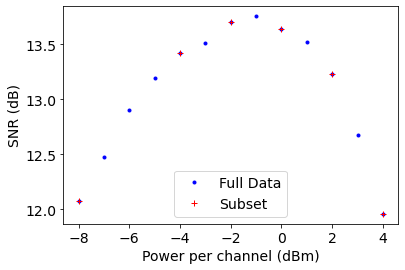

In [3]:
figure_num = 6
if figure_num == 3:
    inds = [0, 3, 6, 9, 12]  # for -8 to 4 dBm, five meas. Figure 3
    snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
    pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
elif figure_num == 5:
    inds = [0, 5, 12]  # for -8 to 4 dBm, three meas. with a priori peak Figure 5
    snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]]])
    pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]]])
elif figure_num == 6:
    inds = [0, 2, 4, 6, 8, 12]  # for -8 to 4 dBm, six meas. Figure 6
    snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]], snr[inds[5]]])
    pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]], pch[inds[5]]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

Get SSFM simulation predictions and apply TRx B2B noise:

In [4]:
snr_ssfm = np.array([19.49, 20.64, 15.09]) 
pch_ssfm = np.array([ -4, 0, 4])
snr_ssfm_m = np.array([apply_b2b(i, convert_to_db(convert_to_lin(14.8))) for i in snr_ssfm])

Import simple physical model, based on Equation 6 and get optimal values via least squares based on SSFM simulation results with a priori parameter estimates:

In [5]:
sim_model = simple_model()
opt_vals = sim_model.fit(pch_ssfm.reshape(len(pch_ssfm),), snr_ssfm.reshape(len(snr_ssfm),),
                         init_guess = np.array([1e-5, 1e3]))
a_opt, b_opt = opt_vals[0]
pch_sim_comp = np.linspace(pch[0], pch[-1], 30)
seed = 1 # for reproducibility, can fix random seed
snr_sim = snr_simple_gen(pch_sim_comp, a_opt, b_opt, seed, 0.5/3)
print(a_opt)
print(b_opt)

4.175696351100312e-06
4496.438144330627


Generate physical model ensemble for Figure 2:

In [6]:
pch_pred_phys = np.copy(pch)
snr_phys_ensemble = []
for i in range(5):
    snr_phys_ensemble.append(snr_simple_gen(pch_pred_phys, a_opt, b_opt, i, 0.5/3))
snr_phys_ensemble_ave = np.mean(snr_phys_ensemble, axis=0)

Take peak physical model SNR prediction, calculate the power that corresponds to a 2 dB penalty either side

In [7]:
pch_peak_search = np.linspace(pch[-1], pch[0], 100)
snr_pk = max(snr_simple_gen(pch_peak_search, a_opt, b_opt, i, 1e-3))
snr_pk - 2.0
print(snr[0])  # high power max 
print(pch[0])
print(snr[-1])  # low power min
print(pch[-1])

11.9585323936485
4.0
12.0792581047977
-8.0


Figure 2 generation:

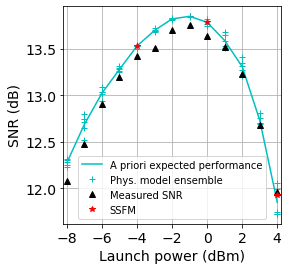

In [8]:
f, ax = plt.subplots()
plt.plot(pch_pred_phys, snr_phys_ensemble_ave, 'c-', label='A priori expected performance')
plt.plot(pch_pred_phys, snr_phys_ensemble[0], 'c+', label='Phys. model ensemble')
plt.plot(pch_pred_phys, snr_phys_ensemble[1], 'c+')
plt.plot(pch_pred_phys, snr_phys_ensemble[2], 'c+')
plt.plot(pch_pred_phys, snr_phys_ensemble[3], 'c+')
plt.plot(pch_pred_phys, snr_phys_ensemble[4], 'c+')
plt.plot(pch, snr, 'k^', label='Measured SNR')
plt.plot(pch_ssfm, snr_ssfm_m, 'r*', label='SSFM')
plt.xlim([-8.2, 4.2])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.xlabel("Launch power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
plt.show()

Compute model error w.r.t. full dataset:

In [9]:
mae_phys_model = np.mean(((snr - snr_phys_ensemble_ave)**2)**0.5)
mae_phys_model

0.12163204553346701

**Train physics-informed and standard GPs**

In [10]:
num_pts_phys = 15
pch_test = np.linspace(pch[0], pch[-1], num_pts_phys).reshape(-1,1)
snr_phys_test = snr_simple_gen(np.linspace(pch[0], pch[-1], num_pts_phys), a_opt, b_opt, 1, 0.5/3).reshape(-1,1)
pch_pred = np.arange(pch[-1], pch[0]+0.1, 0.1)

In [11]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub, pch_test, snr_sub, snr_phys_test, pch_pred)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 
print(np.exp(theta_phys))

[7.19717962 3.75064945 0.01140585]


In [12]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_sub, snr_sub, pch_pred)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 
print(np.exp(theta))

[1.54305615 2.60644165 0.02843876]


In [13]:
mu_sk_f, std_sk_f, theta_f, lml_f = train_standard_gp(pch, snr, pch_pred)
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 
print(np.exp(theta_f))

[1.52049704e+01 4.98173112e+00 4.61540319e-03]


Compare all models

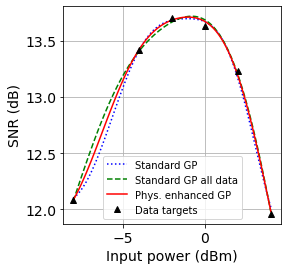

In [14]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk, 'b:', label = 'Standard GP')
ax.plot(pch_pred, mu_sk_f, 'g--', label = 'Standard GP all data')
ax.plot(pch_pred, mu_sk_phys, 'r-', label = 'Phys. enhanced GP')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.show()

Generate Figures 3a, 5a, 6a:

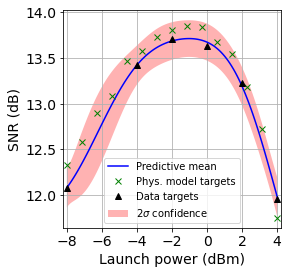

In [15]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk_phys, 'b-', label = 'Predictive mean')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
ax.fill(np.concatenate([pch_pred, pch_pred[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([-8.2, 4.2])
#plt.ylim([11.5, 14.1])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.xlabel("Launch power (dBm)")
plt.ylabel("SNR (dB)")
plt.grid()
plt.legend(prop={'size':10},loc="lower center")
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.show()

Generate Figures 3b, 5b, 6b:

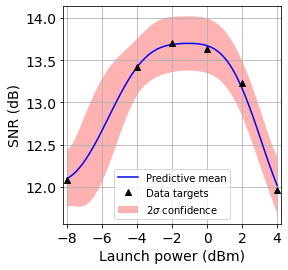

In [16]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk, 'b-', label = 'Predictive mean')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
ax.fill(np.concatenate([pch_pred, pch_pred[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([-8.2, 4.2])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
#plt.ylim([11.5, 14.1])
plt.grid()
plt.xlabel("Launch power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10},loc="lower center")
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.show()

Generate Figures 4, 7:

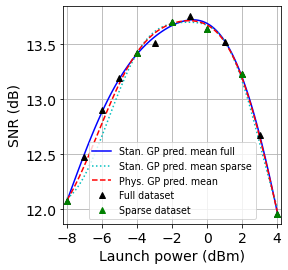

In [17]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk_f, 'b-', label = 'Stan. GP pred. mean full')
ax.plot(pch_pred, mu_sk, 'c:', label = 'Stan. GP pred. mean sparse')
ax.plot(pch_pred, mu_sk_phys, 'r--', label = 'Phys. GP pred. mean')
ax.plot(pch, snr,'k^', label = 'Full dataset')
ax.plot(pch_sub, snr_sub,'g^', label = 'Sparse dataset')
plt.xlim([-8.2, 4.2])
plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.xlabel("Launch power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':9.5})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
plt.show()

Compare MAE w.r.t. data for the physical model enhanced GP trained on subset of the data and standard GP trained on full dataset.

In [18]:
gp_phys_pred, gp_phys_pred_std, _, _ = train_phys_gp(pch_sub, pch_test, snr_sub, snr_phys_test, pch)
gp_pred_f, gp_pred_std_f, _, _ = train_standard_gp(pch, snr, pch)
gp_pred, gp_pred_std, _, _ = train_standard_gp(pch_sub, snr_sub, pch)

In [19]:
mae_phys = np.mean(((snr - gp_phys_pred)**2)**0.5)

In [20]:
mae_stan_f = np.mean(((snr - gp_pred_f)**2)**0.5)

In [21]:
mae_stan = np.mean(((snr - gp_pred)**2)**0.5)

In [22]:
100*(mae_phys - mae_stan_f)/mae_stan_f

1.521772257158097

MAE difference in dB - way below 0.1 dB, which is typically the smallest level people care about in power budgets.

In [23]:
mae_phys - mae_stan_f

0.009920826746262046

In [24]:
mae_stan - mae_stan_f

0.01888981560046199

Relative change in the predictive std compared to full dataset SGP (%):

In [25]:
100*(np.mean(gp_phys_pred_std) - np.mean(gp_pred_std_f))/np.mean(gp_pred_std_f)

152.79536257093702

Relative change in the predictive std compared to subset SGP (%):

In [26]:
100*(np.mean(gp_phys_pred_std) - np.mean(gp_pred_std))/np.mean(gp_pred_std)

-35.58151713559695